In [19]:
# import ogr, osr
# import gdal
import numpy as np
import matplotlib.pyplot as plt
import fiona, shapely, rasterio
from shapely.geometry import Polygon
from shapely.wkt import dumps, loads
from shapely.geometry import asShape, mapping
from rasterio import features, transform
%matplotlib inline

In [2]:
file = fiona.open("SDM324649_full/ll_gda94/sde_shape/whole/VIC/CATCHMENTS/layer/landuse_2014.shp")

In [3]:
area_filter = "POLYGON ((142.79501249253747 -37.62573016158374, 142.79363481285884 -37.832739875957245,\
                        143.06774894788782 -37.83260406398416, 143.0691229156846 -37.62518532754736,\
                        142.79501249253747 -37.62573016158374))"
filter_poly = loads(area_filter)
filtered = list(file.values(bbox=filter_poly.bounds))
len(filtered)

1748

In [4]:
for feature in filtered:
    geom = asShape(feature['geometry'])
    buffered = geom.buffer(-0.001)
#     print(buffered)
    if buffered.is_empty:
        filtered.remove(feature)
    else:
        feature['geometry'] = mapping(buffered)

In [5]:
unique_classes = np.unique([feature['properties']['LC_DESC_14'] for feature in filtered])

In [6]:
print(unique_classes)

['Brassicas' 'Cereals' 'Legumes' 'Pasture and grassland' 'Unknown' 'Water']


In [7]:
unique_classes_dict = {i + 1: unique_classes[i] for i in range(len(unique_classes))}
unique_classes_dict[0] = 'No data'
unique_classes_dict

{0: 'No data',
 1: 'Brassicas',
 2: 'Cereals',
 3: 'Legumes',
 4: 'Pasture and grassland',
 5: 'Unknown',
 6: 'Water'}

In [15]:
unique_classes_inv = {v:k for k,v in unique_classes_dict.items()}

In [29]:
shapes = ((feature['geometry'], unique_classes_inv[feature['properties']['LC_DESC_14']]) for feature in filtered)
x_min, y_min, x_max, y_max = filter_poly.bounds
# x_res = 1022
# y_res = 973
x_res, y_res = (1022, 973)
pixel_size = (x_max - x_min) / x_res
image = features.rasterize(
            ((g, v) for g, v in shapes),
            out_shape=(973, 1022),
#             transform=[x_min, pixel_size, 0, y_max, 0, -pixel_size])
            transform=transform.from_bounds(x_min, y_min, x_max, y_max, x_res, y_res))

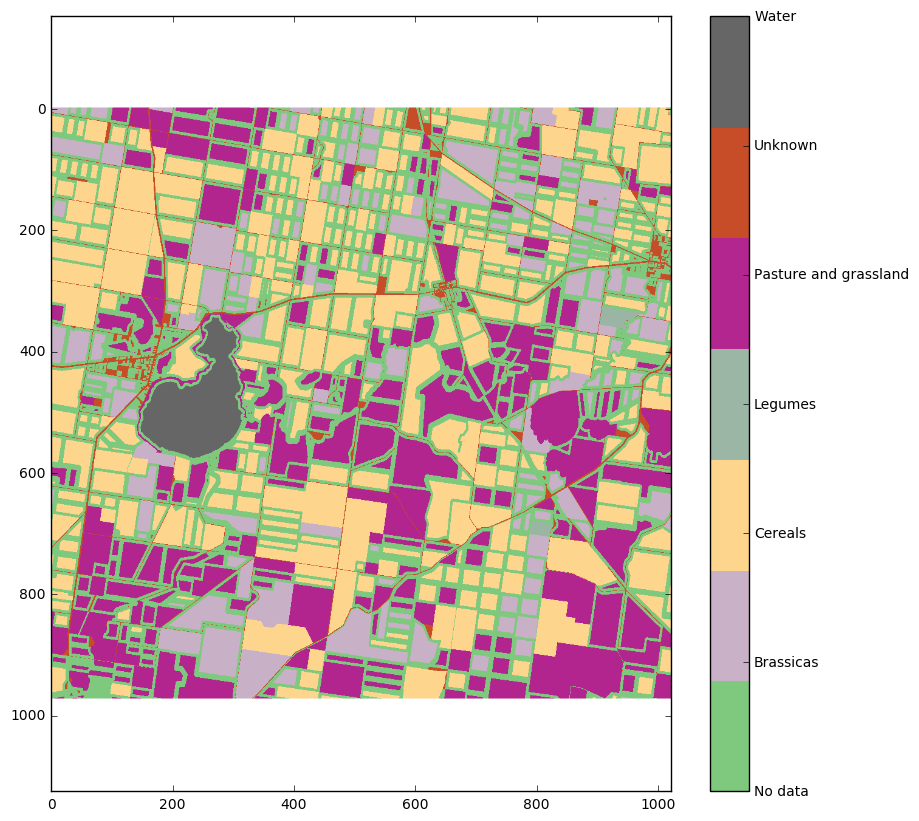

In [30]:
# array = band.ReadAsArray()
plt.figure(figsize=(10, 10))
plt.axis('equal')
im = plt.imshow(image, cmap=plt.cm.get_cmap('Accent', len(unique_classes_dict)))
plt.colorbar(ticks=[0,1,2,3,4,5,6], format=plt.FuncFormatter(lambda val, loc: unique_classes_dict[val]))
plt.show()